Context:

This project explores the results of an A/B test conducted on the mobile game "Cookie Cats." The test focused on the placement of the first in-game gate, which either forced players to wait or make an in-app purchase to progress. Originally placed at level 30, the test version moved it to level 40. Our primary goal is to understand how this change affected player retention and the number of game rounds played.

Firstly, we import packages and data. Then, we get summary information about it.

In [ ]:
import kaggle
import zipfile
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu


## function to load and display main dataset information
def load(path, info=True):
    
    ## checks the type of the dataset
    if path.endswith('.csv'):
        read = pd.read_csv(path)
    elif path.endswith('.xlsx'):
        read = pd.read_excel(path)
        
    ## main information about a dataset
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS Q-------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
            # shows which columns have what data types
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                                "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read

## Importing the data
## Extracting file from zip
zip_refer = zipfile.ZipFile('cookie_cats.csv.zip')

## Extracting file to dir
zip_refer.extractall()

## Closing the zip file
zip_refer.close()

## Get the csv file
path = 'cookie_cats.csv'
rawdata = load(path, info=True)

## Displaying the first few rows of the dataframe
print(rawdata.head(10))


In [340]:

# Checking if all user IDs are unique
all_unique_users = rawdata['userid'].nunique() == rawdata.shape[0]
print(f"All user IDs are unique: {all_unique_users}")

# Defining a function to calculate main summary statistics
def additional_summary_stats(series):
    stats = {
        'mean': series.mean(),
        'median': series.median(),
        'std_dev': series.std(),
        'variance': series.var(),
        'range': series.max() - series.min(),
        'iqr': series.quantile(0.75) - series.quantile(0.25),
        'skewness': series.skew(),
        'kurtosis': series.kurtosis(),
        'cv': series.std() / series.mean() if series.mean() != 0 else None
    }
    return stats

# Summary statistics for gamerounds with specified percentiles
percentiles = [0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]
summary_stats = rawdata['sum_gamerounds'].describe(percentiles).T
additional_stats = pd.Series(additional_summary_stats(rawdata['sum_gamerounds']))

# Combining the basic and additional summary statistics into one DataFrame
summary_stats_df = pd.concat([summary_stats, additional_stats])
print(summary_stats_df)


All user IDs are unique: True
count       90189.000000
mean           51.872457
std           195.050858
min             0.000000
1%              0.000000
5%              1.000000
10%             1.000000
20%             3.000000
50%            16.000000
80%            67.000000
90%           134.000000
95%           221.000000
99%           493.000000
max         49854.000000
mean           51.872457
median         16.000000
std_dev       195.050858
variance    38044.837028
range       49854.000000
iqr            46.000000
skewness      185.436313
kurtosis    47130.369631
cv              3.760201
dtype: float64


Now we want to see the data, for any outliers or inconsistencies. That is why we get histograms of game_rounds before any transformations to it.

Summary Statistics:
         count  median       mean         std    max
version                                             
gate_30  44700    17.0  52.456264  256.716423  49854
gate_40  45489    16.0  51.298776  103.294416   2640


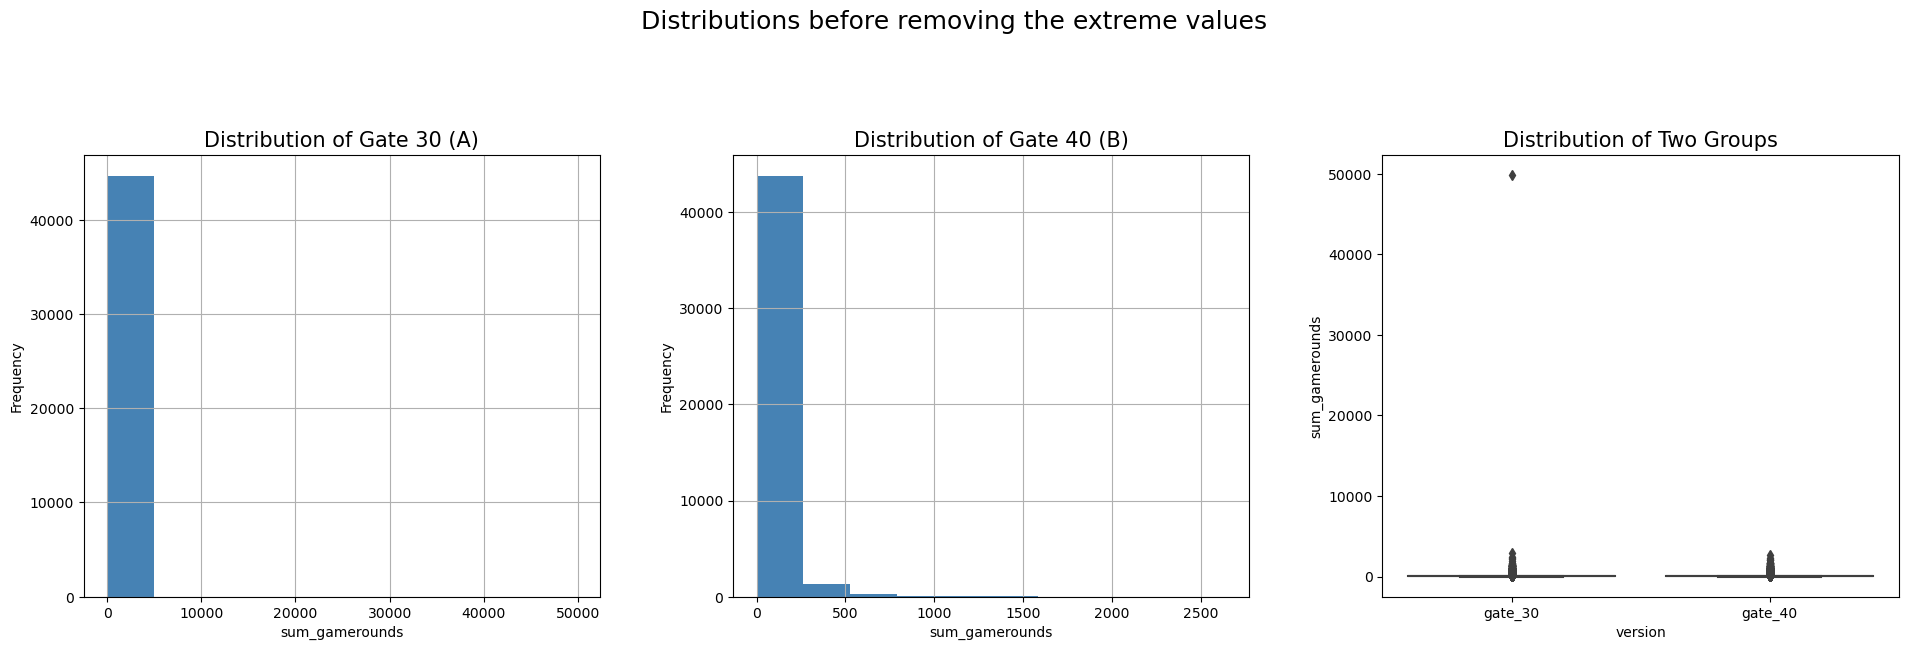

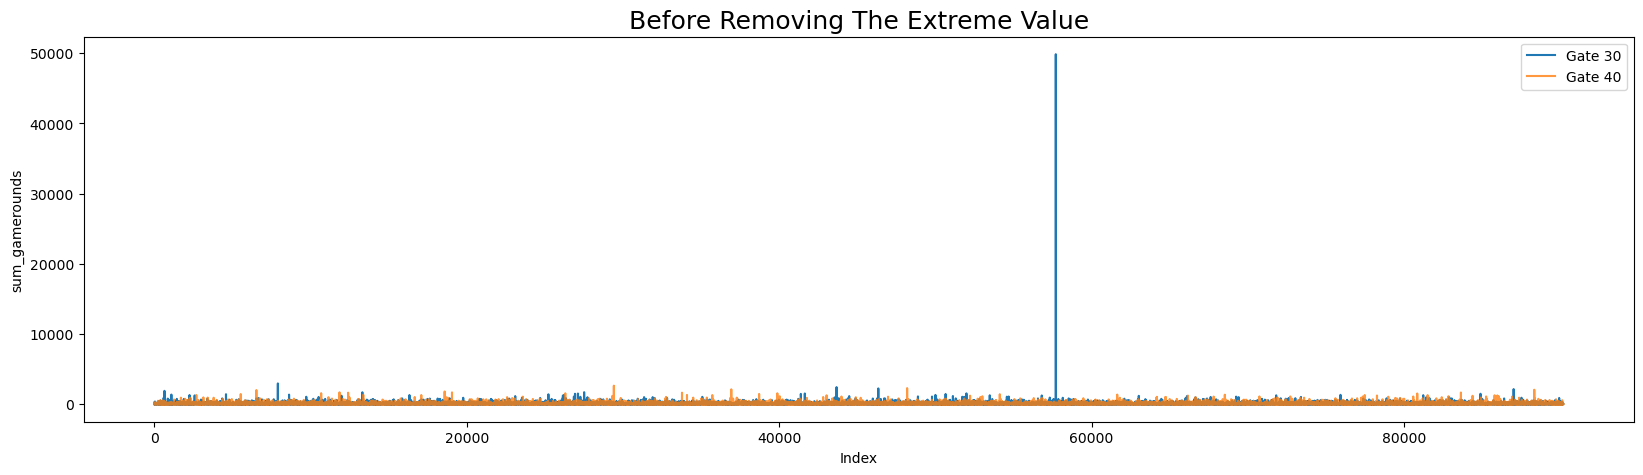

In [341]:
def ab_group_summary_stats(df, column, group_col):
    # Summary statistics for A/B groups
    summary_stats = df.groupby(group_col)[column].agg(["count", "median", "mean", "std", "max"])
    print("Summary Statistics:")
    print(summary_stats)

    # Plotting histograms and boxplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Histogram for Gate 30 aka (A)
    df[df[group_col] == "gate_30"].hist(column, ax=axes[0], color="steelblue")
    axes[0].set_title("Distribution of Gate 30 (A)", fontsize=15)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Frequency")

    # Histogram for Gate 40 aka (B)
    df[df[group_col] == "gate_40"].hist(column, ax=axes[1], color="steelblue")
    axes[1].set_title("Distribution of Gate 40 (B)", fontsize=15)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Frequency")

    # Boxplot for both groups
    sns.boxplot(x=group_col, y=column, data=df, ax=axes[2])
    axes[2].set_title("Distribution of Two Groups", fontsize=15)
    axes[2].set_xlabel(group_col)
    axes[2].set_ylabel(column)

    plt.suptitle("Distributions before removing the extreme values", fontsize=18)
    plt.tight_layout(pad=4)
    plt.show()

    # Plotting time series for both groups
    plt.figure(figsize=(20, 5))
    df[df[group_col] == "gate_30"].reset_index().set_index("index")[column].plot(label="Gate 30", legend=True)
    df[df[group_col] == "gate_40"].reset_index().set_index("index")[column].plot(label="Gate 40", legend=True, alpha=0.8)
    plt.title("Before Removing The Extreme Value", fontsize=18)
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

ab_group_summary_stats(rawdata, 'sum_gamerounds', 'version')

In [ ]:
Now we can clearly see one extreme value of Gate 30 (A) group. We remove it as it skews our data to extreme levels. 
Then, after we check to see the histograms and distribution of the two groups.

Summary Statistics:
                   count       mean         std  min   1%   5%  10%  20%   50%  \
sum_gamerounds  90188.0  51.320253  102.682719  0.0  0.0  1.0  1.0  3.0  16.0   

                 80%    90%    95%    99%     max  
sum_gamerounds  67.0  134.0  221.0  493.0  2961.0  


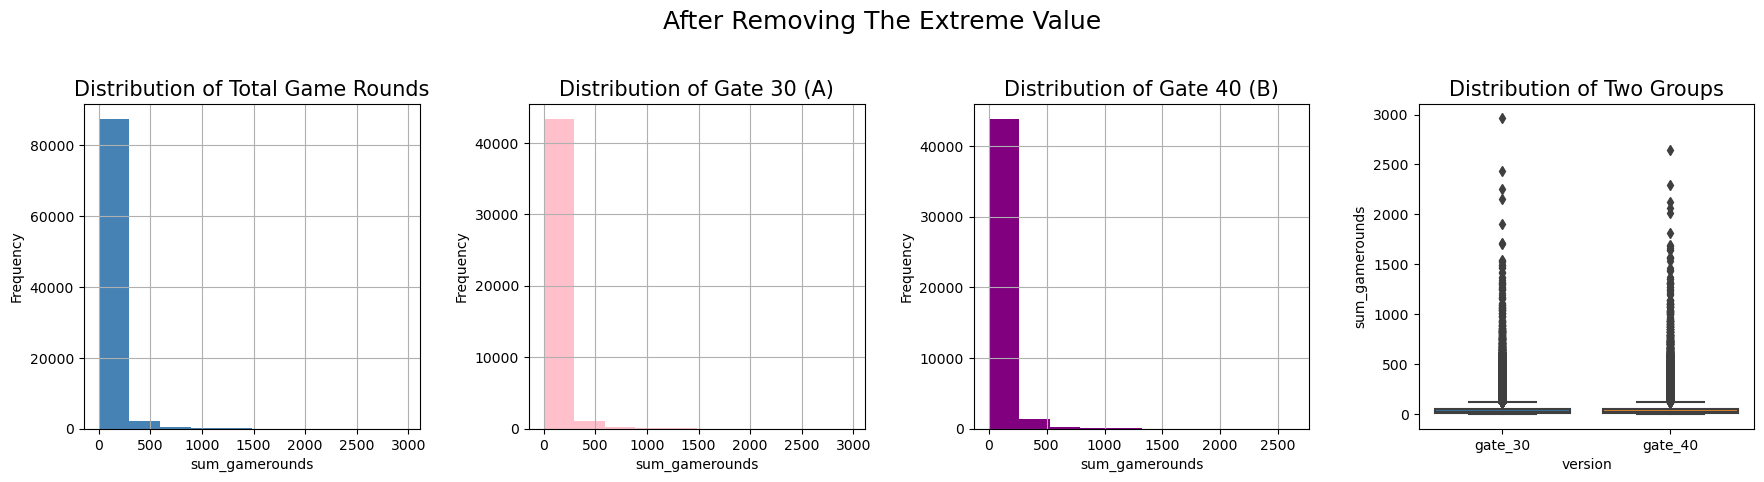

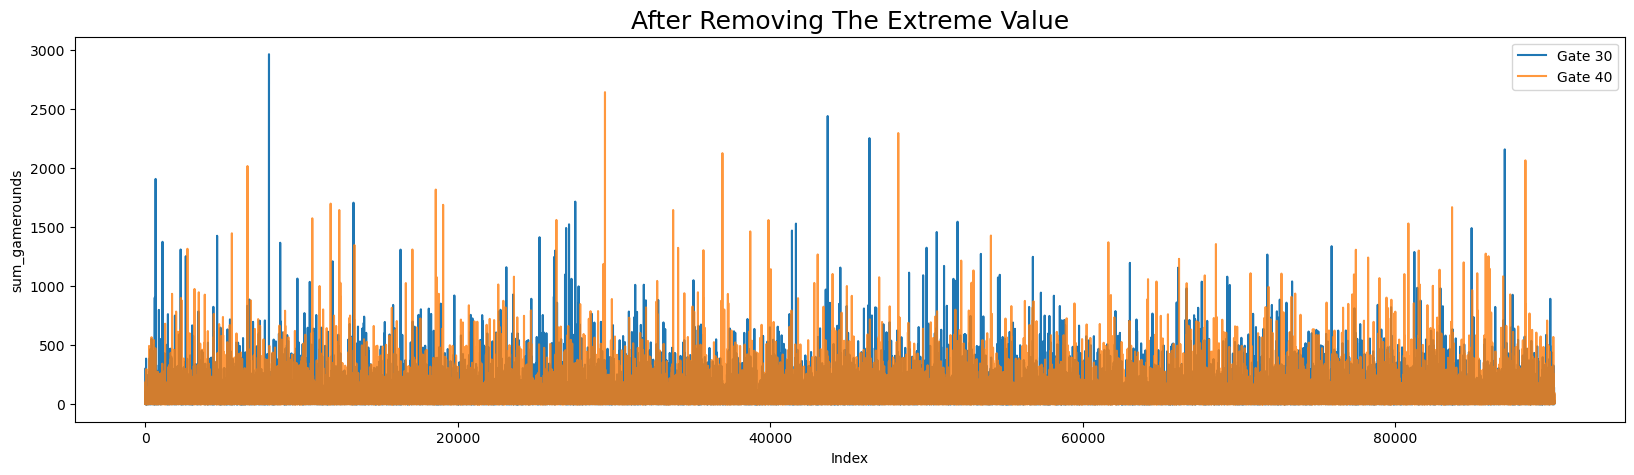

In [342]:
def plot_after_removing_extremes(df, column, group_col):
    # Removing extreme value ( we have one very clear outlier in our dataset (in gate_30) thus, we remove it)
    df = df[df[column] < df[column].max()]
    
    # Summary Statisticts
    summary_stats = df[column].describe(percentiles=[0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]).to_frame().T
    print("Summary Statistics:\n", summary_stats)
    
    # Plotting histograms and boxplot
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    # Histogram for Total Game Rounds
    df[column].hist(ax=axes[0], color="steelblue")
    axes[0].set_title("Distribution of Total Game Rounds", fontsize=15)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Frequency")
    
    # Histogram for Gate 30 (A)
    df[df[group_col] == "gate_30"][column].hist(ax=axes[1], color="pink")
    axes[1].set_title("Distribution of Gate 30 (A)", fontsize=15)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Frequency")
    
    # Histogram for Gate 40 (B)
    df[df[group_col] == "gate_40"][column].hist(ax=axes[2], color="purple")
    axes[2].set_title("Distribution of Gate 40 (B)", fontsize=15)
    axes[2].set_xlabel(column)
    axes[2].set_ylabel("Frequency")
    
    # Boxplot for both groups
    sns.boxplot(x=group_col, y=column, data=df, ax=axes[3])
    axes[3].set_title("Distribution of Two Groups", fontsize=15)
    axes[3].set_xlabel(group_col)
    axes[3].set_ylabel(column)
    
    plt.suptitle("After Removing The Extreme Value", fontsize=18)
    plt.tight_layout(pad=2)
    plt.show()

    plt.figure(figsize=(20, 5))
    df[df[group_col] == "gate_30"].reset_index().set_index("index")[column].plot(label="Gate 30", legend=True)
    df[df[group_col] == "gate_40"].reset_index().set_index("index")[column].plot(label="Gate 40", legend=True, alpha=0.8)
    plt.title("After Removing The Extreme Value", fontsize=18)
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

plot_after_removing_extremes(rawdata, 'sum_gamerounds', 'version')

Now we want to see how many users played how many game rounds. 

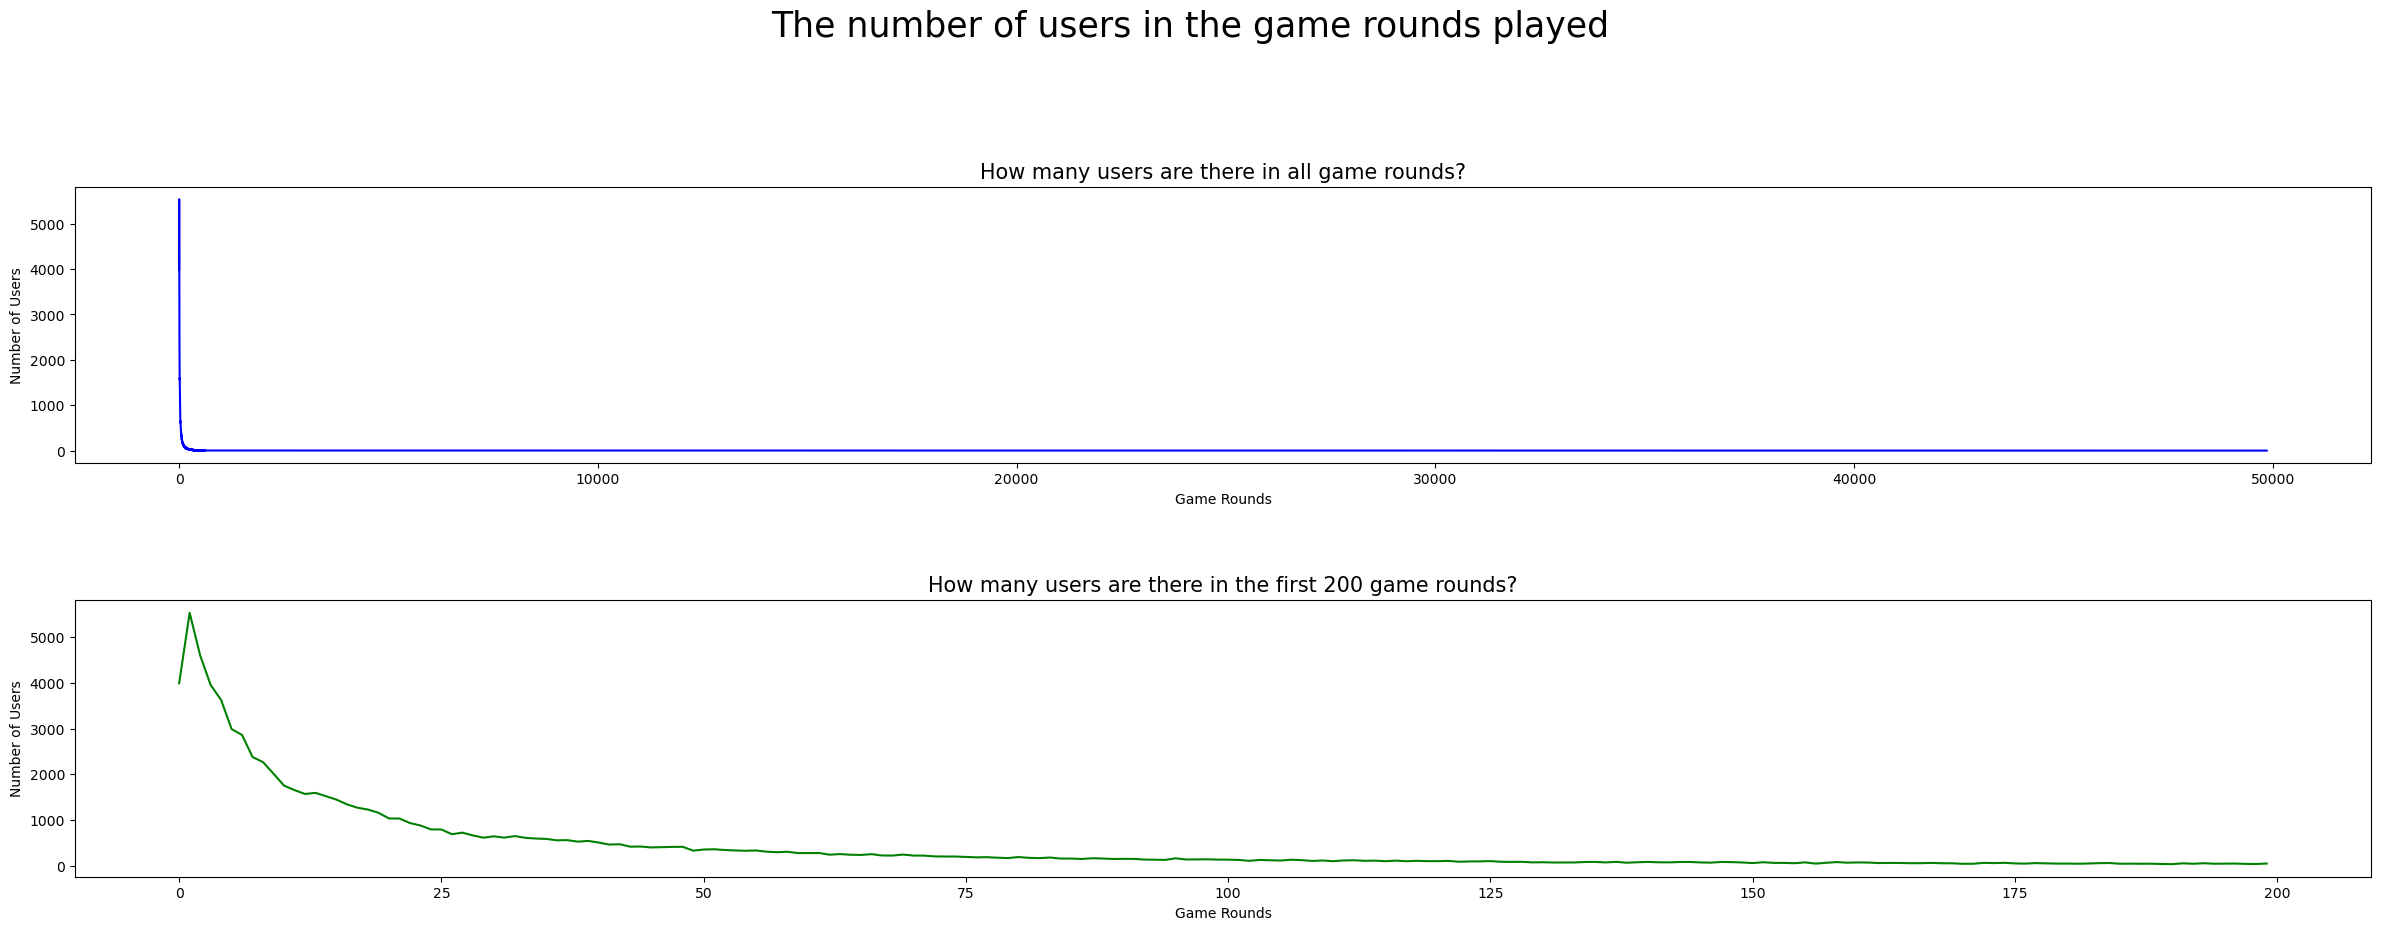

    sum_gamerounds  userid
0                0    3994
1                1    5538
2                2    4606
3                3    3958
4                4    3629
5                5    2992
6                6    2861
7                7    2379
8                8    2267
9                9    2013
10              10    1752
11              11    1654
12              12    1570
13              13    1594
14              14    1519
15              15    1446
16              16    1342
17              17    1269
18              18    1228
19              19    1158


In [343]:
def plot_user_counts_by_game_rounds(df, user_col, game_rounds_col, top_n=300):
 #   Plots the number of users by the number of game rounds played.
    
    # Creating the subplots
    fig, axes = plt.subplots(2, 1, figsize=(25, 10))
    
    # Plotting for all game rounds
    df.groupby(game_rounds_col)[user_col].count().plot(ax=axes[0], color='blue')
    axes[0].set_title("How many users are there in all game rounds?", fontsize=15)
    axes[0].set_xlabel("Game Rounds")
    axes[0].set_ylabel("Number of Users")
    
    # Plotting for the first top_n game rounds
    df.groupby(game_rounds_col)[user_col].count()[:top_n].plot(ax=axes[1], color='green')
    axes[1].set_title(f"How many users are there in the first {top_n} game rounds?", fontsize=15)
    axes[1].set_xlabel("Game Rounds")
    axes[1].set_ylabel("Number of Users")
    
    # Title
    plt.suptitle("The number of users in the game rounds played", fontsize=25)
    plt.tight_layout(pad=5)
    plt.show()
    
    # Print the top 20 game rounds with user counts
    top_20_game_rounds = df.groupby(game_rounds_col)[user_col].count().reset_index().head(20)
    print(top_20_game_rounds)

# Example usage
plot_user_counts_by_game_rounds(rawdata, 'userid', 'sum_gamerounds', top_n=200)


We can see that almost 4000 people downloaded the game and did not play it even once. This could be for numerous reasons such as:
1.)They may have no free time to play game 
2.)Some users did not like the app when they opened and decided not to play it  etc.

The number of users decreases as the levels progress this is logical because:
a.)Most of users played the game at early stage and they didn't get "hooked" thus, they stopped playing it.
b.)They did not progress as they wanted, got stuck on the same level and decided to stop playing it.

Doing research and collecting data about the game and users would help to understand user churn. The difficulty of the game can be measured.

In the game world player retention is key, for making the most amount of money. Thus, we will focus on it. We get the summary statistics.

In [344]:


def ab_summary_stats(df, group_col, target_col):
   ## Summary stats for different groups (a,b)
    summary_stats = df.groupby(group_col)[target_col].agg(["count", "median", "mean", "std", "max"])
    return summary_stats

def retention_summary(df, ret1_col, ret7_col):
   ## Summary stats for retention.
    
    ret1_counts = df[ret1_col].value_counts().sort_index()
    ret7_counts = df[ret7_col].value_counts().sort_index()

    retention_stats = pd.DataFrame({
        "RET1_COUNT": ret1_counts,
        "RET7_COUNT": ret7_counts,
        "RET1_RATIO": ret1_counts / len(df),
        "RET7_RATIO": ret7_counts / len(df)
    })

    return retention_stats

ab_stats = ab_summary_stats(rawdata, "version", "sum_gamerounds")
print("A/B Groups Summary Stats:")
print(ab_stats)

retention_stats = retention_summary(rawdata, "retention_1", "retention_7")
print("\nRetention Summary Stats:")
print(retention_stats)


A/B Groups Summary Stats:
         count  median       mean         std    max
version                                             
gate_30  44700    17.0  52.456264  256.716423  49854
gate_40  45489    16.0  51.298776  103.294416   2640

Retention Summary Stats:
       RET1_COUNT  RET7_COUNT  RET1_RATIO  RET7_RATIO
False       50036       73408     0.55479    0.813935
True        40153       16781     0.44521    0.186065


In [345]:

def create_combined_retention(df, ret1_col, ret7_col):
    
    #Creating combined retention columns and generate summary statistics.
    df["Retention"] = np.where((df[ret1_col] == True) & (df[ret7_col] == True), 1, 0)
    df["NewRetention"] = df[ret1_col].astype(str) + "-" + df[ret7_col].astype(str)
    return df.groupby(["version", "NewRetention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"]).reset_index()

rawdata["version"] = np.where(rawdata["version"] == "gate_30", "A", "B")

# Summary statistics for A/B groups
ab_stats = summarize_ab_groups(rawdata, "sum_gamerounds")
print("A/B Groups Summary Stats:")
print(ab_stats)

# Summary statistics for retention at day 1
ret1_stats = summarize_retention(rawdata, "version", "retention_1", "sum_gamerounds")
print("\nRetention Day 1 Summary Stats:")
print(ret1_stats)

# Summary statistics for retention at day 7
ret7_stats = summarize_retention(rawdata, "version", "retention_7", "sum_gamerounds")
print("\nRetention Day 7 Summary Stats:")
print(ret7_stats)

# Combined retention statistics
combined_retention_stats = create_combined_retention(rawdata, "retention_1", "retention_7")
print("\nCombined Retention Summary Stats:")
print(combined_retention_stats)

# Displaing the first 25 rows of the modified dataframe
print("\nFirst 25 rows of the dataframe:")
print(rawdata.head(25))


A/B Groups Summary Stats:
         count  median       mean         std    max
version                                             
A        44700    17.0  52.456264  256.716423  49854
B        45489    16.0  51.298776  103.294416   2640

Retention Day 1 Summary Stats:
                     count  median       mean         std    max
version retention_1                                             
A       False        24666     6.0  18.379591  319.423232  49854
        True         20034    48.0  94.411700  135.037697   2961
B       False        25370     6.0  16.340402   35.925756   1241
        True         20119    49.0  95.381182  137.887256   2640

Retention Day 7 Summary Stats:
                     count  median        mean         std    max
version retention_7                                              
A       False        36198    11.0   25.796508   43.316158    981
        True          8502   105.0  165.962479  568.000576  49854
B       False        37210    11.0   25.8563

In [346]:
# Defining A/B groups
rawdata["version"] = np.where(rawdata.version == "A", "A", "B")
rawdata.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


Now after we have summary statistics, as well as we have cleerly defined group A and B we can do an AB test to determine whether we should move the gates to level 40 or keep it at level 30.
This is done by performing hypothesis testing. Firstly, we will check the main assumptions such as variance homogeneity and does the data follow normal distribution. Then, the code will apply an adequate test for the data and will see whether we reject H0 or fail to do.

In [347]:
def AB_Test(dataframe, group, target):
    

    # Split A/B groups
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Testing main assumptions
    # Assumption: Normality test using Shapiro-Wilk Test
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Dist is Normal 
    # H1: Dist is not Normal 

    if not ntA and not ntB:  
        #Split into parametric and non-parametric
        # Parametric Test
        # Assumption: Homogeneity of variances 
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Variances are equal 
        # H1: Variances are not equal 
        print(leveneTest)
        if not leveneTest:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 
            # H1: M1 != M2 
        else:
            # Heterogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # Non-Parametric Test 
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
    print(ttest)
    # Result
    result = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05], 
        "p-value": [ttest]
    })
    result["Test Type"] = np.where(not ntA and not ntB, "Parametric", "Non-Parametric")
    result["AB Hypothesis"] = np.where(result["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    result["Comment"] = np.where(result["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Adding Homogeneity column if Parametric Test
    if not ntA and not ntB:
        result["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        result = result[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        result = result[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    
    # Printing Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return result


ab_test_results = AB_Test(dataframe=rawdata, group="version", target="sum_gamerounds")
print(ab_test_results)



0.05020880772044255
# A/B Testing Hypothesis
H0: A == B
H1: A != B 

        Test Type      AB Hypothesis   p-value                  Comment
0  Non-Parametric  Fail to Reject H0  0.050209  A/B groups are similar!


C:\Users\Admin\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we can see we perform a non-parametric test and we get that the p-value is not significant, But it is very close to 0.05 thus, we continue our exploration with bootstrap analysis.

This analysis uses bootstrapping to evaluate the retention rates of two versions (A and B) of a product at 1-day and 7-day intervals. The goal is to determine if there is a statistically significant difference in retention rates between the two versions and calculate the probability that the retention rate for version A is higher than that for version B.
We first simulate 500 bootstrap iterations.Then, we plot the kernel density estimate of the bootstrapped mean 1-day retention rates for each version. Afterwards, we calculate the percent difference in means between the two versions and plotting the difference.Then, we repeat the steps for 7 day retention.

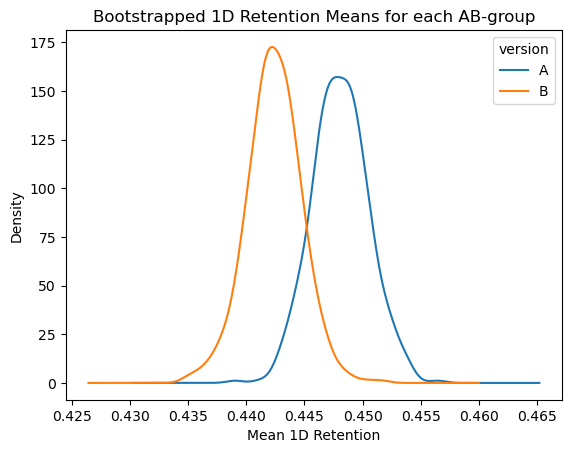

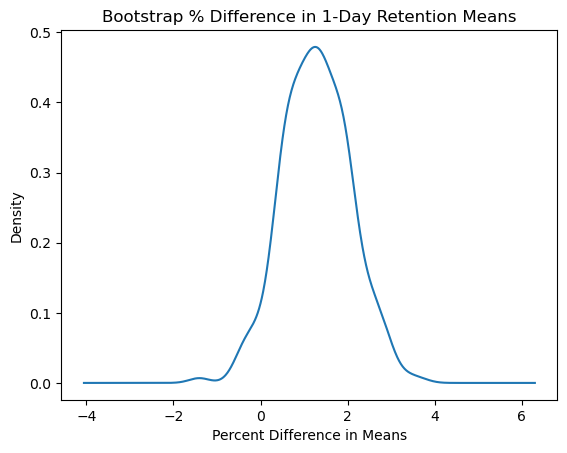

Probability that 1-day retention is greater when the gate is at level 30: 95.4%


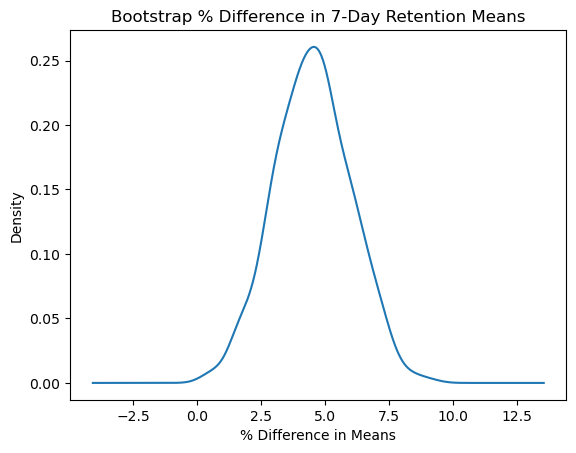

Probability that 7-day retention is greater when the gate is at level 30: 100.0%


In [348]:
# Looping for simulations
boot_1d = []
iterations = 500
for i in range(iterations):
    boot_mean = rawdata.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a Df
boot_1d = pd.DataFrame(boot_1d)

# Kernel Density Estimate plot of the bootstrap dist
ax = boot_1d.plot.kde()
ax.set_title('Bootstrapped 1D Retention Means for each AB-group')
ax.set_xlabel('Mean 1D Retention')
plt.show()

# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d['A'] - boot_1d['B']) / boot_1d['B']) * 100

# Plotting the % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Percent Difference in Means')
ax.set_title('Bootstrap % Difference in 1-Day Retention Means')
plt.show()

# Calculating the prob that 1-day retention is > when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])
print(f"Probability that 1-day retention is greater when the gate is at level 30: {prob:.1%}")

# Calculating 7D retention for both AB-groups
rawdata.groupby('version')['retention_7'].mean()

# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(iterations):
    boot_mean = rawdata.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a Df
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = ((boot_7d['A'] - boot_7d['B']) / boot_7d['B']) * 100

# Plotting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% Difference in Means')
ax.set_title('Bootstrap % Difference in 7-Day Retention Means')
plt.show()

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()
print(f"Probability that 7-day retention is greater when the gate is at level 30: {prob:.1%}")

The bootstrapped analysis suggests a very high probability that version A has a better retention rate at both 1-day and 7-day intervals compared to version B. The probability is particularly high for 7-day retention.So in fact we should not switch to gate 40, as the retention rate should go down with high prob. This can be counterintuitive at first but the main reason in my mind is the fact that if we make the game too continuous to play they get bored quicker than we stop them and give them a break.
Final conclusion:

Keep gate 30.